# Comparing accounts of task decomposition

In [1]:
import sys; sys.path.append('..')
import run_models, automated_design, analysis, graph_partition
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import analyze_v1_11_tools as analyze_tools

%matplotlib inline
%load_ext autoreload
%autoreload 2

analysis.set_mpl_style()

tomov_interop could not load matlab


R[write to console]: Loading required package: dfidx

R[write to console]: 
Attaching package: ‘dfidx’


R[write to console]: The following object is masked from ‘package:stats’:

    filter




In [2]:
graph_list = automated_design.download_bdm_graphs_8c()
nstates = len(graph_list[0].state_list)
assert all(len(g.state_list) == nstates for g in graph_list)

In [3]:
models = [m for m in analysis.models if m.model is not None]

In [4]:
scores = np.zeros((len(models), len(graph_list), nstates))

for gi, g in enumerate(tqdm(graph_list)):
    for mi, m in enumerate(models):
        scores[mi, gi] = m.model(g)['scores']

  0%|          | 0/11117 [00:00<?, ?it/s]

/Users/carlos/pu/tmp/rrtd/env/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/carlos/pu/tmp/rrtd/env/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


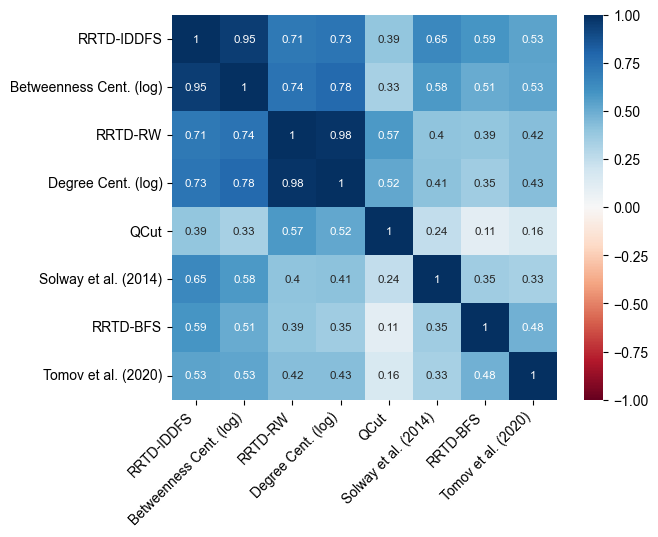

In [5]:
def corrcoef_stdhack(arr):
    '''
    When doing graph-wise cross-algo correlations, need to avoid nan's when SD is 0, since algorithms at time predict uniform.
    '''
    # We take care to check for predictions that are numerically close to uniform, since they otherwise can result in nonsensical correlations.
    def _is_uniform(a):
        return np.allclose(a, a[0])
    is_uni = np.array([_is_uniform(a) for a in arr], dtype=bool)

    c = np.corrcoef(arr)
    c[is_uni, :] = np.nan
    c[:, is_uni] = np.nan
    return c

corrmat = np.zeros((len(graph_list), len(models), len(models)))
for gi in range(len(graph_list)):
    corrmat[gi] = corrcoef_stdhack(scores[:, gi, :])
# Drop nan correlations.
corrmat = np.nanmean(corrmat, axis=0)

idx_models = {m.key: m for m in models}
order = [
    idx_models['iddfs'],
    idx_models['log_betweenness_centrality'],
    idx_models['rw'],
    idx_models['log_degree_centrality'],
    idx_models['qcut'],
    idx_models['solwayr_partition_greedy_uniformexit_require_all_partitions_have_non_exit'],
    idx_models['bfs'],
    idx_models['tomov'],
]

cs = [m.name for m in order]
order_idx = [models.index(m) for m in order]
corrdf = pd.DataFrame(corrmat[order_idx][:, order_idx], columns=cs, index=cs)

f, ax = plt.subplots(figsize=(7, 5)) # dimensions seem ideal for getting colorbar + graph to be same height
kw = dict(vmin=-1, vmax=+1, cmap='RdBu', annot=True, square=True)
g = sns.heatmap(corrdf, ax=ax, annot_kws=dict(fontsize='small'), **kw)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')

analysis.savefig('model-correlations.*')